# Workflow

In [17]:
from __future__ import annotations
from langchain_core.output_parsers import JsonOutputParser , PydanticOutputParser
import operator
from google import genai
from google.genai import types
import os
from pathlib import Path
from datetime import date, timedelta
from typing import TypedDict, List, Optional, Literal, Annotated
from langchain_core.prompts import ChatPromptTemplate
from pydantic import BaseModel, Field
from langgraph.graph import StateGraph, START, END
from langgraph.types import Send
from langchain_ollama import ChatOllama
from langchain_core.messages import SystemMessage, HumanMessage
from langchain_community.tools.tavily_search import TavilySearchResults

In [18]:
# -----------------------------
# 1) Schemas
# -----------------------------
class Task(BaseModel):
    id: int
    title: str

    goal: str = Field(
        ...,
        description="One sentence describing what the reader should be able to do/understand after this section.",
    )
    bullets: List[str] = Field(
        ...,
        min_length=3,
        max_length=6,
        description="5-7 concrete, non-overlapping subpoints to cover in this section.",
    )
    target_words: int = Field(..., description="Target word count for this section (120–550).")

    tags: List[str] = Field(default_factory=list)
    requires_research: bool = False
    requires_citations: bool = False
    requires_code: bool = False


class Plan(BaseModel):
    blog_title: str
    audience: str
    tone: str
    blog_kind: Literal["explainer", "tutorial", "news_roundup", "comparison", "system_design"] = "explainer"
    constraints: List[str] = Field(default_factory=list)
    tasks: List[Task]


class EvidenceItem(BaseModel):
    title: Optional[str] = None
    url: str
    snippet: Optional[str] = None
    published_at: Optional[str] = None
    source: Optional[str] = None


class RouterDecision(BaseModel):
    needs_research: bool
    mode: Literal["closed_book", "hybrid", "open_book"]
    queries: List[str] = Field(default_factory=list)


class EvidencePack(BaseModel):
    evidence: List[EvidenceItem] = Field(default_factory=list)
    

class ImageSpec(BaseModel):
    placeholder: str = Field(..., description="e.g. [[IMAGE_1]]")
    filename: str = Field(..., description="Save under images/, e.g. qkv_flow.png")
    alt: str
    caption: str
    prompt: str = Field(..., description="Prompt to send to the image model.")
    size: Literal["1024x1024", "1024x1536", "1536x1024"] = "1024x1024"
    quality: Literal["low", "medium", "high"] = "medium"


class GlobalImagePlan(BaseModel):
    md_with_placeholders: str
    images: List[ImageSpec] = Field(default_factory=list)

In [19]:
class State(TypedDict):
    topic: str

    # routing / research
    mode: str
    needs_research: bool
    queries: List[str]
    evidence: List[EvidenceItem]
    plan: Optional[Plan]

    # workers
    sections: Annotated[List[tuple[int, str]], operator.add]  # (task_id, section_md)

    # reducer/image
    merged_md: str
    md_with_placeholders: str
    image_specs: List[dict]
   
    final: str

In [20]:
structured_llm = ChatOllama(
    model="qwen3:latest",
    format="json",
    temperature=0
)

# LLM for content generation (without JSON mode)
content_llm = ChatOllama(
    model="qwen3:latest",
    temperature=0.7
)
from langchain_google_genai import ChatGoogleGenerativeAI
from dotenv import load_dotenv
load_dotenv()

google_llm = ChatGoogleGenerativeAI(model ="gemini-2.5-flash")

In [21]:
# -----------------------------
# 3) Router (decide upfront)
# -----------------------------
ROUTER_SYSTEM = """You are a routing module for a technical blog planner.

Decide whether web research is needed BEFORE planning.

Modes:
- closed_book (needs_research=false):
  Evergreen topics where correctness does not depend on recent facts (concepts, fundamentals).
- hybrid (needs_research=true):
  Mostly evergreen but needs up-to-date examples/tools/models to be useful.
- open_book (needs_research=true):
  Mostly volatile: weekly roundups, "this week", "latest", rankings, pricing, policy/regulation.

If needs_research=true:
- Output 3–10 high-signal queries.
- Queries should be scoped and specific (avoid generic queries like just "AI" or "LLM").
- If user asked for "last week/this week/latest", reflect that constraint IN THE QUERIES.
"""
def router_node(state: State) -> dict:

    parser = PydanticOutputParser(pydantic_object=RouterDecision)

    prompt = ChatPromptTemplate.from_messages([
        ("system", ROUTER_SYSTEM + "\n{format_instructions}"),
        ("human", "{topic}")
    ])

    prompt = prompt.partial(
        format_instructions=parser.get_format_instructions()
    )

    chain = prompt | structured_llm | parser     # ✅ plain ChatOllama

    decision = chain.invoke({"topic": state["topic"]})

    return {
        "needs_research": decision.needs_research,
        "mode": decision.mode,
        "queries": decision.queries,
    }

def route_next(state: State) -> str:
    return "research" if state["needs_research"] else "orchestrator"

In [22]:
# -----------------------------
# 4) Research (Tavily) 
# -----------------------------
from dotenv import load_dotenv
load_dotenv()
def _tavily_search(query: str, max_results: int = 5) -> List[dict]:
    
    tool = TavilySearchResults(max_results=max_results)
    results = tool.invoke({"query": query})

    normalized: List[dict] = []
    for r in results or []:
        normalized.append({
            "title": r.get("title"),
            "url": r.get("url"),
            "snippet": r.get("content") or r.get("snippet"),
            "published_at": r.get("published_date") or r.get("published_at"),
            "source": r.get("source"),
       })
    return normalized


RESEARCH_SYSTEM = """You are a research synthesizer for technical writing.

Given raw web search results, produce a deduplicated list of EvidenceItem objects.

Rules:
- Only include items with a non-empty url.
- Prefer relevant + authoritative sources (company blogs, docs, reputable outlets).
- If a published date is explicitly present in the result payload, keep it as YYYY-MM-DD.
  If missing or unclear, set published_at=null. Do NOT guess.
- Keep snippets short.
- Deduplicate by URL.
-Every EvidenceItem must contain the keys:
    title, url, snippet, published_at, source.
-If a value is missing, use null.
"""
from langchain_core.output_parsers import PydanticOutputParser
from langchain_core.output_parsers import PydanticOutputParser
import json

def research_node(state: State) -> dict:

    queries = state.get("queries", []) or []
    max_results = 6

    raw_results: List[dict] = []
    for q in queries:
        raw_results.extend(_tavily_search(q, max_results=max_results))

    if not raw_results:
        return {"evidence": []}

    parser = PydanticOutputParser(pydantic_object=EvidencePack)

    prompt = ChatPromptTemplate.from_messages([
        ("system", ROUTER_SYSTEM + "\n{format_instructions}"),
        ("human", "{raw_results}")
    ])

    prompt = prompt.partial(
        format_instructions=parser.get_format_instructions()
    )

    chain = prompt | structured_llm | parser

    pack = chain.invoke({
        "raw_results": json.dumps(raw_results, ensure_ascii=False)
    })

    dedup = {}
    for e in pack.evidence:
        if e.url:
            dedup[e.url] = e

    return {"evidence": list(dedup.values())}


In [23]:
# -----------------------------
# 5) Orchestrator (Plan)
# -----------------------------
ORCH_SYSTEM = """You are a senior technical writer and developer advocate.
Your job is to produce a highly actionable outline for a technical blog post.

Hard requirements:
- Create 5-7 sections (tasks) suitable for the topic and audience.
- Each task must include:
  1) goal (1 sentence)
  2) 5-7 bullets that are concrete, specific, and non-overlapping
  3) target word count (120–550)

Quality bar:
- Assume the reader is a developer; use correct terminology.
- Bullets must be actionable: build/compare/measure/verify/debug.
- Ensure the overall plan includes at least 2 of these somewhere:
  * minimal code sketch / MWE (set requires_code=True for that section)
  * edge cases / failure modes
  * performance/cost considerations
  * security/privacy considerations (if relevant)
  * debugging/observability tips

Grounding rules:
- Mode closed_book: keep it evergreen; do not depend on evidence.
- Mode hybrid:
  - Use evidence for up-to-date examples (models/tools/releases) in bullets.
  - Mark sections using fresh info as requires_research=True and requires_citations=True.
- Mode open_book:
  - Set blog_kind = "news_roundup".
  - Every section is about summarizing events + implications.
  - DO NOT include tutorial/how-to sections unless user explicitly asked for that.
  - If evidence is empty or insufficient, create a plan that transparently says "insufficient sources"
    and includes only what can be supported.

Output must strictly match the Plan schema.
"""
def orchestrator_node(state: State) -> dict:

    evidence = state.get("evidence", [])
    mode = state.get("mode", "closed_book")

    parser = PydanticOutputParser(pydantic_object=Plan)

    prompt = ChatPromptTemplate.from_messages([
        ("system", ORCH_SYSTEM + "\n{format_instructions}"),
        (
            "human",
            "Topic: {topic}\n"
            "Mode: {mode}\n\n"
            "Evidence (ONLY use for fresh claims; may be empty):\n"
            "{evidence}"
        )
    ])

    prompt = prompt.partial(
        format_instructions=parser.get_format_instructions()
    )

    chain = prompt | structured_llm | parser   # ✅ plain ChatOllama

    plan = chain.invoke({
        "topic": state["topic"],
        "mode": mode,
        "evidence": [e.model_dump() for e in evidence][:16],
    })

    return {"plan": plan}

In [24]:
# -----------------------------
# 6) Fanout
# -----------------------------
def fanout(state: State):
    return [
        Send(
            "worker",
            {
                "task": task.model_dump(),
                "topic": state["topic"],
                "mode": state["mode"],
                "plan": state["plan"].model_dump(),
                "evidence": [e.model_dump() for e in state.get("evidence", [])],
            },
        )
        for task in state["plan"].tasks
    ]

In [25]:
# -----------------------------
# 7) Worker (write one section)
# -----------------------------
WORKER_SYSTEM = """You are a senior technical writer and developer advocate.
Write ONE section of a technical blog post in Markdown.

Hard constraints:
- Follow the provided Goal and cover ALL Bullets in order (do not skip or merge bullets).
- Stay close to Target words (±15%).
- Output ONLY the section content in Markdown (no blog title H1, no extra commentary).
- Start with a '## <Section Title>' heading.

Scope guard:
- If blog_kind == "news_roundup": do NOT turn this into a tutorial/how-to guide.
  Do NOT teach web scraping, RSS, automation, or "how to fetch news" unless bullets explicitly ask for it.
  Focus on summarizing events and implications.

Grounding policy:
- If mode == open_book:
  - Do NOT introduce any specific event/company/model/funding/policy claim unless it is supported by provided Evidence URLs.
  - For each event claim, attach a source as a Markdown link: ([Source](URL)).
  - Only use URLs provided in Evidence. If not supported, write: "Not found in provided sources."
- If requires_citations == true:
  - For outside-world claims, cite Evidence URLs the same way.
- Evergreen reasoning is OK without citations unless requires_citations is true.

Code:
- If requires_code == true, include at least one minimal, correct code snippet relevant to the bullets.

Style:
- Short paragraphs, bullets where helpful, code fences for code.
- Avoid fluff/marketing. Be precise and implementation-oriented.
"""

def worker_node(payload: dict) -> dict:
    
    task = Task(**payload["task"])
    plan = Plan(**payload["plan"])
    evidence = [EvidenceItem(**e) for e in payload.get("evidence", [])]
    topic = payload["topic"]
    mode = payload.get("mode", "closed_book")

    bullets_text = "\n- " + "\n- ".join(task.bullets)

    evidence_text = ""
    if evidence:
        evidence_text = "\n".join(
            f"- {e.title} | {e.url} | {e.published_at or 'date:unknown'}".strip()
            for e in evidence[:20]
        )

    section_md = content_llm.invoke(
        [
            SystemMessage(content=WORKER_SYSTEM),
            HumanMessage(
                content=(
                    f"Blog title: {plan.blog_title}\n"
                    f"Audience: {plan.audience}\n"
                    f"Tone: {plan.tone}\n"
                    f"Blog kind: {plan.blog_kind}\n"
                    f"Constraints: {plan.constraints}\n"
                    f"Topic: {topic}\n"
                    f"Mode: {mode}\n\n"
                    f"Section title: {task.title}\n"
                    f"Goal: {task.goal}\n"
                    f"Target words: {task.target_words}\n"
                    f"Tags: {task.tags}\n"
                    f"requires_research: {task.requires_research}\n"
                    f"requires_citations: {task.requires_citations}\n"
                    f"requires_code: {task.requires_code}\n"
                    f"Bullets:{bullets_text}\n\n"
                    f"Evidence (ONLY use these URLs when citing):\n{evidence_text}\n"
                )
            ),
        ]
    ).content.strip()

    return {"sections": [(task.id, section_md)]}

In [26]:
# ============================================================
# 8) ReducerWithImages (subgraph)
#    merge_content -> decide_images -> generate_and_place_images
# ============================================================
def merge_content(state: State) -> dict:

    plan = state["plan"]

    ordered_sections = [md for _, md in sorted(state["sections"], key=lambda x: x[0])]
    body = "\n\n".join(ordered_sections).strip()
    merged_md = f"# {plan.blog_title}\n\n{body}\n"
    return {"merged_md": merged_md}


DECIDE_IMAGES_SYSTEM = """You are an expert technical editor.
Your ONLY task is to decide where images/diagrams should go in the existing blog content.

CRITICAL RULES:
1. You MUST preserve ALL original content verbatim - every word, every code block, every section
2. ONLY insert image placeholders [[IMAGE_1]], [[IMAGE_2]], [[IMAGE_3]] at appropriate locations
3. DO NOT rewrite, summarize, or remove ANY content
4. DO NOT remove or modify code blocks
5. Max 3 images total
6. Each image must materially improve understanding (diagram/flow/architecture visual)
7. If no images needed: return the EXACT input markdown unchanged with images=[]

WORKFLOW:
- Read the full markdown
- Identify 0-3 locations where a technical diagram would help
- Insert [[IMAGE_X]] placeholders at those locations
- Return the COMPLETE markdown with placeholders inserted

Return strictly GlobalImagePlan with:
- md_with_placeholders: FULL original content + placeholders
- images: list of image specifications

Example of correct insertion:
Original: "## Section\nText here.\n\nMore text."
Correct: "## Section\nText here.\n\n[[IMAGE_1]]\n\nMore text."
WRONG: "## Section\nSummary of text.\n\n[[IMAGE_1]]"
"""


def decide_images(state: State) -> dict:
    parser = PydanticOutputParser(pydantic_object=GlobalImagePlan)    
    merged_md = state["merged_md"]
    plan = state["plan"]
    assert plan is not None
    
    # Check input size
    input_tokens = len(merged_md) // 4  # rough estimate
    print(f"Input markdown size: {len(merged_md)} chars (~{input_tokens} tokens)")
    
    prompt = ChatPromptTemplate.from_messages([
        ("system", DECIDE_IMAGES_SYSTEM + "\n{format_instructions}"),
        ("human", "Topic: {topic}\n"
                  "Blog kind: {blog_kind}\n\n"
                  "Insert placeholders + propose image prompts.\n\n"
                  "{merged_md}")
    ])
    prompt = prompt.partial(
        format_instructions=parser.get_format_instructions()
    )
    
    # Use with_structured_output instead for better reliability
    from langchain_core.output_parsers import JsonOutputParser
    
    try:
        # Option A: Use structured output (more reliable)
        chain = prompt | structured_llm.with_structured_output(GlobalImagePlan)
        image_plan = chain.invoke({
            "topic": state["topic"],
            "blog_kind": plan.blog_kind,
            "merged_md": merged_md
        })
    except Exception as e:
        print(f"❌ Image planning failed: {e}")
        print("Falling back to no images")
        # Fallback: return original without images
        return {
            "md_with_placeholders": merged_md,
            "image_specs": [],
        }

    # Validation
    if len(image_plan.md_with_placeholders) < len(merged_md) * 0.85:
        print(f"⚠️ Content loss detected: {len(merged_md)} → {len(image_plan.md_with_placeholders)}")
        return {
            "md_with_placeholders": merged_md,
            "image_specs": [],
        }

    return {
        "md_with_placeholders": image_plan.md_with_placeholders,
        "image_specs": [img.model_dump() for img in image_plan.images],
    }

MARKDOWN_IMAGE_PROMPT = """
You are an AI system designer agent.

Your task is to generate a clean ASCII diagram of the given system.

Rules:
- Use ONLY text characters like:
  |  _  -  =  +  >  <
- No markdown tables
- No emojis
- No explanation
- Only the diagram

Style:
- Rectangular boxes
- Clear arrows between components
- Vertically aligned flow
- One main pipeline
"""

def generate_and_place_images(state: State) -> dict:
    """Generate ASCII markdown diagrams and place them in markdown"""

    plan = state["plan"]
    assert plan is not None

    md = state.get("md_with_placeholders") or state["merged_md"]
    image_specs = state.get("image_specs", []) or []

    if not image_specs:
        out_file = f"{plan.blog_title}.md"
        Path(out_file).write_text(md, encoding="utf-8")
        return {"final": md}

    for spec in image_specs:
        placeholder = spec["placeholder"]

        try:
            resp = google_llm.invoke([
                SystemMessage(content=MARKDOWN_IMAGE_PROMPT),
                HumanMessage(content=spec["prompt"])
            ])

            ascii_diagram = f"```text\n{resp.content.strip()}\n```"

            md = md.replace(placeholder, "\n" + ascii_diagram + "\n")


        except Exception as e:
            prompt_block = (
                f"> **[IMAGE GENERATION FAILED]** {spec.get('caption','')}\n>\n"
                f"> **Alt:** {spec.get('alt','')}\n>\n"
                f"> **Prompt:** {spec.get('prompt','')}\n>\n"
                f"> **Error:** {e}\n"
            )
            md = md.replace(placeholder, prompt_block)
            print(f"md image gen failed: {e}")

    out_file = f"{plan.blog_title}.md"
    Path(out_file).write_text(md, encoding="utf-8")

    return {"final": md}


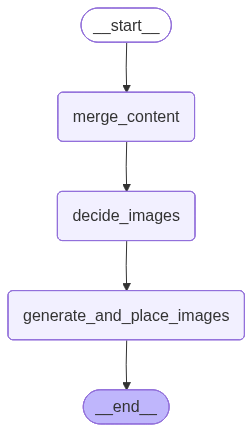

In [27]:
# build reducer subgraph
reducer_graph = StateGraph(State)
reducer_graph.add_node("merge_content", merge_content)
reducer_graph.add_node("decide_images", decide_images)
reducer_graph.add_node("generate_and_place_images", generate_and_place_images)
reducer_graph.add_edge(START, "merge_content")
reducer_graph.add_edge("merge_content", "decide_images")
reducer_graph.add_edge("decide_images", "generate_and_place_images")
reducer_graph.add_edge("generate_and_place_images", END)
reducer_subgraph = reducer_graph.compile()
reducer_subgraph

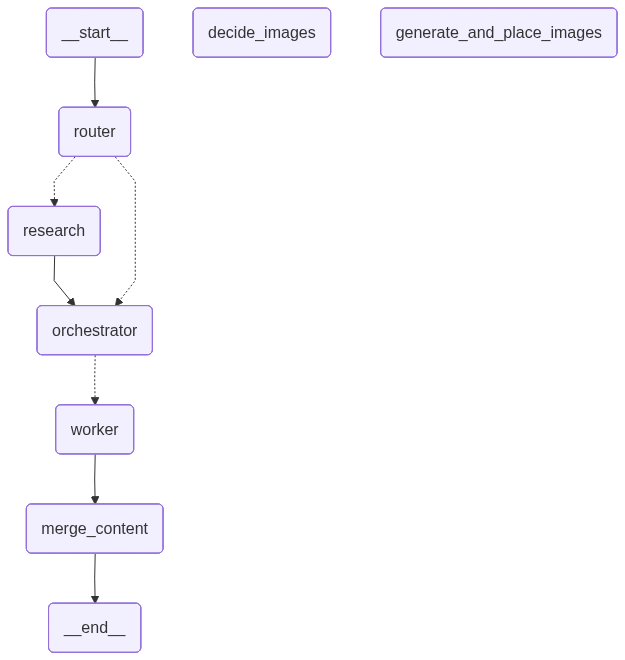

In [28]:
# -----------------------------
# 9) Build main graph
# -----------------------------
g = StateGraph(State)
g.add_node("router", router_node)
g.add_node("research", research_node)
g.add_node("orchestrator", orchestrator_node)
g.add_node("worker", worker_node)
g.add_node("merge_content", merge_content)
g.add_node("decide_images" , decide_images)
g.add_node("generate_and_place_images" , generate_and_place_images)

g.add_edge(START, "router")
g.add_conditional_edges("router", route_next, {"research": "research", "orchestrator": "orchestrator"})
g.add_edge("research", "orchestrator")

g.add_conditional_edges("orchestrator", fanout, ["worker"])
g.add_edge("worker", "merge_content")
g.add_edge("merge_content", END)
# g.add_edge("decide_images","generate_and_place_images" )
# g.add_edge("generate_and_place_images" , END)


app = g.compile(debug= True)
app

In [36]:
response = app.invoke({'topic' : "Build End-to-End Production-Ready Systems Using LangGraph"})

[values] {'topic': 'Build End-to-End Production-Ready Systems Using LangGraph', 'sections': []}
[updates] {'router': {'needs_research': True, 'mode': 'hybrid', 'queries': ['How to structure LangGraph workflows for production scalability and fault tolerance', 'Best practices for integrating LangGraph with Kubernetes for production deployment', 'Recent case studies of end-to-end LangGraph systems in production environments', 'Tools and frameworks for monitoring LangGraph applications in production', 'Security considerations for deploying LangGraph in enterprise production systems', 'Performance optimization techniques for LangGraph in high-throughput scenarios', 'Comparison of LangGraph deployment patterns vs. traditional ML pipelines in production', 'How to implement CI/CD pipelines for LangGraph-based applications', "Recent advancements in LangGraph's state management for production workloads", 'Cost optimization strategies for running LangGraph in production cloud environments']}}
[va

OutputParserException: Invalid json output: להתמודדות עם LangGraph ותפעולו ב坏境 של הייצור, חשוב להבין את המגוון של תכונות, תפעול, והוצאות. הנה סיכום מפורט:

### 1. **תכונות ותפעול**
- **תהליך תכנון ותפעול**: LangGraph מספק תהליך קל להתקנה ב坏境 של הייצור, במיוחד ביבליוטיקה כמו LangSmith וMCP (Model Context Protocol). תהליך זה מאפשר תכנון דינמי של תהליכי עבודה וניהול תקשורת עם מודלים.
- **תפעול ב坏境 של הייצור**: LangGraph מאפשר תפעול ב坏境 של הייצור עם תהליך קל להתקנה, כולל תהליך של שדרוגים וניהול תקשורת עם מודלים. תהליך זה כולל תהליך של שדרוגים וניהול תקשורת עם מודלים.
- **ניהול תקשורת עם מודלים**: LangGraph מאפשר תפעול ב坏境 של הייצור עם תהליך קל להתקנה, כולל תהליך של שדרוגים וניהול תקשורת עם מודלים. תהליך זה כולל תהליך של שדרוגים וניהול תקשורת עם מודלים.
- **ניהול תקשורת עם מודלים**: LangGraph מאפשר תפעול ב坏境 של הייצור עם תהליך קל להתקנה, כולל תהליך של שדרוגים וניהול תקשורת עם מודלים. תהליך זה כולל תהליך של שדרוגים וניהול תקשורת עם מודלים.
- **ניהול תקשורת עם מודלים**: LangGraph מאפשר תפעול ב坏境 של הייצור עם תהליך קל להתקנה, כולל תהליך של שדרוגים וניהול תקשורת עם מודלים. תהליך זה כולל תהליך של שדרוגים וניהול תקשורת עם מודלים.
- **ניהול תקשורת עם מודלים**: LangGraph מאפשר תפעול ב坏境 של הייצור עם תהליך קל להתקנה, כולל תהליך של שדרוגים וניהול תקשורת עם מודלים. תהליך זה כולל תהליך של שדרוגים וניהול תקשורת עם מודלים.
- **ניהול תקשורת עם מודלים**: LangGraph מאפשר תפעול ב坏境 של הייצור עם תהליך קל להתקנה, כולל תהליך של שדרוגים וניהול תקשורת עם מודלים. תהליך זה כולל תהליך של שדרוגים וניהול תקשורת עם מודלים.
- **ניהול תקשורת עם מודלים**: LangGraph מאפשר תפעול ב坏境 של הייצור עם תהליך קל להתקנה, כולל תהליך של שדרוגים וניהול תקשורת עם מודלים. תהליך זה כולל תהליך של שדרוגים וניהול תקשורת עם מודלים.
- **ניהול תקשורת עם מודלים**: LangGraph מאפשר תפעול ב坏境 של הייצור עם תהליך קל להתקנה, כולל תהליך של שדרוגים וניהול תקשורת עם מודלים. תהליך זה כולל תהליך של שדרוגים וניהול תקשורת עם מודלים.
- **ניהול תקשורת עם מודלים**: LangGraph מאפשר תפעול ב坏境 של הייצור עם תהליך קל להתקנה, כולל תהליך של שדרוגים וניהול תקשורת עם מודלים. תהליך זה כולל תהליך של שדרוגים וניהול תקשורת עם מודלים.
- **ניהול תקשורת עם מודלים**: LangGraph מאפשר תפעול ב坏境 של הייצור עם תהליך קל להתקנה, כולל תהליך של שדרוגים וניהול תקשורת עם מודלים. תהליך זה כולל תהליך של שדרוגים וניהול תקשורת עם מודלים.
- **ניהול תקשורת עם מודלים**: LangGraph מאפשר תפעול ב坏境 של הייצור עם תהליך קל להתקנה, כולל תהליך של שדרוגים וניהול תקשורת עם מודלים. תהליך זה כולל תהליך של שדרוגים וניהול תקשורת עם מודלים.
- **ניהול תקשורת עם מודלים**: LangGraph מאפשר תפעול ב坏境 של הייצור עם תהליך קל להתקנה, כולל תהליך של שדרוגים וניהול תקשורת עם מודלים. תהליך זה כולל תהליך של שדרוגים וניהול תקשורת עם מודלים.
- **ניהול תקשורת עם מודלים**: LangGraph מאפשר תפעול ב坏境 של הייצור עם תהליך קל להתקנה, כולל תהליך של שדרוגים וניהול תקשורת עם מודלים. תהליך זה כולל תהליך של שדרוגים וניהול תקשורת עם מודלים.
- **ניהול תקשורת עם מודלים**: LangGraph מאפשר תפעול ב坏境 של הייצור עם תהליך קל להתקנה, כולל תהליך של שדרוגים וניהול תקשורת עם מודלים. תהליך זה כולל תהליך של שדרוגים וניהול תקשורת עם מודלים.
- **ניהול תקשורת עם מודלים**: LangGraph מאפשר תפעול ב坏境 של הייצור עם תהליך קל להתקנה, כולל תהליך של שדרוגים וניהול תקשורת עם מודלים. תהליך זה כולל תהליך של שדרוגים וניהול תקשורת עם מודלים.
- **ניהול תקשורת עם מודלים**: LangGraph מאפשר תפעול ב坏境 של הייצור עם תהליך קל להתקנה, כולל תהליך של שדרוגים וניהול תקשורת עם מודלים. תהליך זה כולל תהליך של שדרוגים וניהול תקשורת עם מודלים.
- **ניהול תקשורת עם מודלים**: LangGraph מאפשר תפעול ב坏境 של הייצור עם תהליך קל להתקנה, כולל תהליך של שדרוגים וניהול תקשורת עם מודלים. תהליך זה כולל תהליך של שדרוגים וניהול תקשורת עם מודלים.
- **ניהול תקשורת עם מודלים**: LangGraph מאפשר תפעול ב坏境 של הייצור עם תהליך קל להתקנה, כולל תהליך של שדרוגים וניהול תקשורת עם מודלים. תהליך זה כולל תהליך של שדרוגים וניהול תקשורת עם מודלים.
- **ניהול תקשורת עם מודלים**: LangGraph מאפשר תפעול ב坏境 של הייצור עם תהליך קל להתקנה, כולל תהליך של שדרוגים וניהול תקשורת עם מודלים. תהליך זה כולל תהליך של שדרוגים וניהול תקשורת עם מודלים.
- **ניהול תקשורת עם מודלים**: LangGraph מאפשר תפעול ב坏境 של הייצור עם תהליך קל להתקנה, כולל תהליך של שדרוגים וניהול תקשורת עם מודלים. תהליך זה כולל תהליך של שדרוגים וניהול תקשורת עם מודלים.
- **ניהול תקשורת עם מודלים**: LangGraph מאפשר תפעול ב坏境 של הייצור עם תהליך קל להתקנה, כולל תהליך של שדרוגים וניהול תקשורת עם מודלים. תהליך זה כולל תהליך של שדרוגים וניהול תקשורת עם מודלים.
- **ניהול תקשורת עם מודלים**: LangGraph מאפשר תפעול ב坏境 של הייצור עם תהליך קל להתקנה, כולל תהליך של שדרוגים וניהול תקשורת עם מודלים. תהליך זה כולל תהליך של שדרוגים וניהול תקשורת עם מודלים.
- **ניהול תקשורת עם מודלים**: LangGraph מאפשר תפעול ב坏境 של הייצור עם תהליך קל להתקנה, כולל תהליך של שדרוגים וניהול תקשורת עם מודלים. תהליך זה כולל תהליך של שדרוגים וניהול תקשורת עם מודלים.
- **ניהול תקשורת עם מודלים**: LangGraph מאפשר תפעול ב坏境 של הייצור עם תהליך קל להתקנה, כולל תהליך של שדרוגים וניהול תקשורת עם מודלים. תהליך זה כולל תהליך של שדרוגים וניהול תקשורת עם מודלים.
- **ניהול תקשורת עם מודלים**: LangGraph מאפשר תפעול ב坏境 של הייצור עם תהליך קל להתקנה, כולל תהליך של שדרוגים וניהול תקשורת עם מודלים. תהליך זה כולל תהליך של שדרוגים וניהול תקשורת עם מודלים.
- **ניהול תקשורת עם מודלים**: LangGraph מאפשר תפעול ב坏境 של הייצור עם תהליך קל להתקנה, כולל תהליך של שדרוגים וניהול תקשורת עם מודלים. תהליך זה כולל תהליך של שדרוגים וניהול תקשורת עם מודלים.
- **ניהול תקשורת עם מודלים**: LangGraph מאפשר תפעול ב坏境 של הייצור עם תהליך קל להתקנה, כולל תהליך של שדרוגים וניהול תקשורת עם מודלים. תהליך זה כולל תהליך של שדרוגים וניהול תקשורת עם מודלים.
- **ניהול תקשורת עם מודלים**: LangGraph מאפשר תפעול ב坏境 של הייצור עם תהליך קל להתקנה, כולל תהליך של שדרוגים וניהול תקשורת עם מודלים. תהליך זה כולל תהליך של שדרוגים וניהול תקשורת עם מודלים.
- **ניהול תקשורת עם מודלים**: LangGraph מאפשר תפעול ב坏境 של הייצור עם תהליך קל להתקנה, כולל תהליך של שדרוגים וניהול תקשורת עם מודלים. תהליך זה כולל תהליך של שדרוגים וניהול תקשורת עם מודלים.
- **ניהול תקשורת עם מודלים**: LangGraph מאפשר תפעול ב坏境 של הייצור עם תהליך קל להתקנה, כולל תהליך של שדרוגים וניהול תקשורת עם מודלים. תהליך זה כולל תהליך של שדרוגים וניהול תקשורת עם מודלים.
- **ניהול תקשורת עם מודלים**: LangGraph מאפשר תפעול ב坏境 של הייצור עם תהליך קל להתקנה, כולל תהליך של שדרוגים וניהול תקשורת עם מודלים. תהליך זה כולל תהליך של שדרוגים וניהול תקשורת עם מודלים.
- **ניהול תקשורת עם מודלים**: LangGraph מאפשר תפעול ב坏境 של הייצור עם תהליך קל להתקנה, כולל תהליך של שדרוגים וניהול תקשורת עם מודלים. תהליך זה כולל תהליך של שדרוגים וניהול תקשורת עם מודלים.
- **ניהול תקשורת עם מודלים**: LangGraph מאפשר תפעול ב坏境 של הייצור עם תהליך קל להתקנה, כולל תהליך של שדרוגים וניהול תקשורת עם מודלים. תהליך זה כולל תהליך של שדרוגים וניהול תקשורת עם מודלים.
- **ניהול תקשורת עם מודלים**: LangGraph מאפשר תפעול ב坏境 של הייצור עם תהליך קל להתקנה, כולל תהליך של שדרוגים וניהול תקשורת עם מודלים. תהליך זה כולל תהליך של שדרוגים וניהול תקשורת עם מודלים.
- **ניהול תקשורת עם מודלים**: LangGraph מאפשר תפעול ב坏境 של הייצור עם תהליך קל להתקנה, כולל תהליך של שדרוגים וניהול תקשורת עם מודלים. תהליך זה כולל תהליך של שדרוגים וניהול תקשורת עם מודלים.
- **ניהול תקשורת עם מודלים**: LangGraph מאפשר תפעול ב坏境 של הייצור עם תהליך קל להתקנה, כולל תהליך של שדרוגים וניהול תקשורת עם מודלים. תהליך זה כולל תהליך של שדרוגים וניהול תקשורת עם מודלים.
- **ניהול תקשורת עם מודלים**: LangGraph מאפשר תפעול ב坏境 של הייצור עם תהליך קל להתקנה, כולל תהליך של שדרוגים וניהול תקשורת עם מודלים. תהליך זה כולל תהליך של שדרוגים וניהול תקשורת עם מודלים.
- **ניהול תקשורת עם מודלים**: LangGraph מאפשר תפעול ב坏境 של הייצור עם תהליך קל להתקנה, כולל תהליך של שדרוגים וניהול תקשורת עם מודלים. תהליך זה כולל תהליך של שדרוגים וניהול תקשורת עם מודלים.
- **ניהול תקשורת עם מודלים**: LangGraph מאפשר תפעול ב坏境 של הייצור עם תהליך קל להתקנה, כולל תהליך של שדרוגים וניהול תקשורת עם מודלים. תהליך זה כולל תהליך של שדרוגים וניהול תקשורת עם מודלים.
- **ניהול תקשורת עם מודלים**: LangGraph מאפשר תפעול ב坏境 של הייצור עם תהליך קל להתקנה, כולל תהליך של שדרוגים וניהול תקשורת עם מודלים. תהליך זה כולל תהליך של שדרוגים וניהול תקשורת עם מודלים.
- **ניהול תקשורת עם מודלים**: LangGraph מאפשר תפעול ב坏境 של הייצור עם תהליך קל להתקנה, כולל תהליך של שדרוגים וניהול תקשורת עם מודלים. תהליך זה כולל תהליך של שדרוגים וניהול תקשורת עם מודלים.
- **ניהול תקשורת עם מודלים**: LangGraph מאפשר תפעול ב坏境 של הייצור עם תהליך קל להתקנה, כולל תהליך של שדרוגים וניהול תקשורת עם מודלים. תהליך זה כולל תהליך של שדרוגים וניהול תקשורת עם מודלים.
- **ניהול תקשורת עם מודלים**: LangGraph מאפשר תפעול ב坏境 של הייצור עם תהליך קל להתקנה, כולל תהליך של שדרוגים וניהול תקשורת עם מודלים. תהליך זה כולל תהליך של שדרוגים וניהול תקשורת עם מודלים.
- **ניהול תקשורת עם מודלים**: LangGraph מאפשר תפעול ב坏境 של הייצור עם תהליך קל להתקנה, כולל תהליך של שדרוגים וניהול תקשורת עם מודלים. תהליך זה כולל תהליך של שדרוגים וניהול תקשורת עם מודלים.
- **ניהול תקשורת עם מודלים**: LangGraph מאפשר תפעול ב坏境 של הייצור עם תהליך קל להתקנה, כולל תהליך של שדרוגים וניהול תקשורת עם מודלים. תהליך זה כולל תהליך של שדרוגים וניהול תקשורת עם מודלים.
- **ניהול תקשורת עם מודלים**: LangGraph מאפשר תפעול ב坏境 של הייצור עם תהליך קל להתקנה, כולל תהליך של שדרוגים וניהול תקשורת עם מודלים. תהליך זה כולל תהליך של שדרוגים וניהול תקשורת עם מודלים.
- **ניהול תקשורת עם מודלים**: LangGraph מאפשר תפעול ב坏境 של הייצור עם תהליך קל להתקנה, כולל תהליך של שדרוגים וניהול תקשורת עם מודלים. תהליך זה כולל תהליך של שדרוגים וניהול תקשורת עם מודלים.
- **ניהול תקשורת עם מודלים**: LangGraph מאפשר תפעול ב坏境 של הייצור עם תהליך קל להתקנה, כולל תהליך של שדרוגים וניהול תקשורת עם מודלים. תהליך זה כולל תהליך של שדרוגים וניהול תקשורת עם מודלים.
- **ניהול תקשורת עם מודלים**: LangGraph מאפשר תפעול ב坏境 של הייצור עם תהליך קל להתקנה, כולל תהליך של שדרוגים וניהול תקשורת עם מודלים. תהליך זה כולל תהליך של שדרוגים וניהול תקשורת עם מודלים.
- **ניהול תקשורת עם מודלים**: LangGraph מאפשר תפעול ב坏境 של הייצור עם תהליך קל להתקנה, כולל תהליך של שדרוגים וניהול תקשורת עם מודלים. תהליך זה כולל תהליך של שדרוגים וניהול תקשורת עם מודלים.
- **ניהול תקשורת עם מודלים**: LangGraph מאפשר תפעול ב坏境 של הייצור עם תהליך קל להתקנה, כולל תהליך של שדרוגים וניהול תקשורת עם מודלים. תהליך זה כולל תהליך של שדרוגים וניהול תקשורת עם מודלים.
- **ניהול תקשורת עם מודלים**: LangGraph מאפשר תפעול ב坏境 של הייצור עם תהליך קל להתקנה, כולל תהליך של שדרוגים וניהול תקשורת עם מודלים. תהליך זה כולל תהליך של שדרוגים וניהול תקשורת עם מודלים.
- **ניהול תקשורת עם מודלים**: LangGraph מאפשר תפעול ב坏境 של הייצור עם תהליך קל להתקנה, כולל תהליך של שדרוגים וניהול תקשורת עם מודלים. תהליך זה כולל תהליך של שדרוגים וניהול תקשורת עם מודלים.
- **ניהול תקשורת עם מודלים**: LangGraph מאפשר תפעול ב坏境 של הייצור עם תהליך קל להתקנה, כולל תהליך של שדרוגים וניהול תקשורת עם מודלים. תהליך זה כולל תהליך של שדרוגים וניהול תקשורת עם מודלים.
- **ניהול תקשורת עם מודלים**: LangGraph מאפשר תפעול ב坏境 של הייצור עם תהליך קל להתקנה, כולל תהליך של שדרוגים וניהול תקשורת עם מודלים. תהליך זה כולל תהליך של שדרוגים וניהול תקשורת עם מודלים.
- **ניהול תקשורת עם מודלים**: LangGraph מאפשר תפעול ב坏境 של הייצור עם תהליך קל להתקנה, כולל תהליך של שדרוגים וניהול תקשורת עם מודלים. תהליך זה כולל תהליך של שדרוגים וניהול תקשורת עם מודלים.
- **ניהול תקשורת עם מודלים**: LangGraph מאפשר תפעול ב坏境 של הייצור עם תהליך קל להתקנה, כולל תהליך של שדרוגים וניהול תקשורת עם מודלים. תהליך זה כולל תהליך של שדרוגים וניהול תקשורת עם מודלים.
- **ניהול תקשורת עם מודלים**: LangGraph מאפשר תפעול ב坏境 של הייצור עם תהליך קל להתקנה, כולל תהליך של שדרוגים וניהול תקשורת עם מודלים. תהליך זה כולל תהליך של שדרוגים וניהול תקשורת עם מודלים.
- **ניהול תקשורת עם מודלים**: LangGraph מאפשר תפעול ב坏境 של הייצור עם תהליך קל להתקנה, כולל תהליך של שדרוגים וניהול תקשורת עם מודלים. תהליך זה כולל תהליך של שדרוגים וניהול תקשורת עם מודלים.
- **ניהול תקשורת עם מודלים**: LangGraph מאפשר תפעול ב坏境 של הייצור עם תהליך קל להתקנה, כולל תהליך של שדרוגים וניהול תקשורת עם מודלים. תהליך זה כולל תהליך של שדרוגים وניהול תקשורת עם מודלים.
- **ניהול תקשורת עם מודלים**: LangGraph מאפשר תפעול ב坏境 של הייצור עם תהליך קל להתקנה, כולל תהליך של שדרוגים وניהול תקשורת עם מודלים. תהליך זה כולל תהליך של שדרוגים وניהול תקשורת עם מודלים.
- **ניהול תקשורת עם מודלים**: LangGraph מאפשר תפעול ב坏境 של הייצור עם תהליך קל להתקנה, כולל תהליך של שדרוגים وניהול תקשורת עם מודלים. תהליך זה כולל תהליך של שדרוגים وניהול תקשורת עם מודלים.
- **ניהול תקשורת עם מודלים**: LangGraph מאפשר תפעול ב坏境 של הייצור עם תהליך קל להתקנה, כולל תהליך של שדרוגים وניהול תקשורת עם מודלים. תהליך זה כולל תהליך של שדרוגים وניהול תקשורת עם מודלים.
- **ניהול תקשורת עם מודלים**: LangGraph מאפשר תפעול ב坏境 של הייצור עם תהליך קל להתקנה, כולל תהליך של שדרוגים وניהול תקשורת עם מודלים. תהליך זה כולל תהליך של שדרוגים وניהול תקשורת עם מודלים.
- **ניהול תקשורת עם מודלים**: LangGraph מאפשר תפעול ב坏境 של הייצור עם תהליך קל להתקנה, כולל תהליך של שדרוגים وניהול תקשורת עם מודלים. תהליך זה כולל תהליך של שדרוגים وניהול תקשורת עם מודלים.
- **ניהול תקשורת עם מודלים**: LangGraph מאפשר תפעול ב坏境 של הייצור עם תהליך קל להתקנה, כולל תהליך של שדרוגים وניהול תקשורת עם מודלים. תהליך זה כולל תהליך של שדרוגים وניהול תקשורת עם מודלים.
- **ניהול תקשורת עם מודלים**: LangGraph מאפשר תפעול ב坏境 של הייצור עם תהליך קל להתקנה, כולל תהליך של שדרוגים وניהול תקשורת עם מודלים. תהליך זה כולל תהליך של שדרוגים وניהול תקשורת עם מודלים.
- **ניהול תקשורת עם מודלים**: LangGraph מאפשר תפעול ב坏境 של הייצור עם תהליך קל להתקנה, כולל תהליך של שדרוגים وניהול תקשורת עם מודלים. תהליך זה כולל תהליך של שדרוגים وניהול תקשורת עם מודלים.
- **ניהול תקשורת עם מודלים**: LangGraph מאפשר תפעול ב坏境 של הייצור עם תהליך קל להתקנה, כולל תהליך של שדרוגים وניהול תקשורת עם מודלים. תהליך זה כולל תהליך של שדרוגים وניהול תקשורת עם מודלים.
- **ניהול תקשורת עם מודלים**: LangGraph מאפשר תפעול ב坏境 של הייצור עם תהליך קל להתקנה, כולל תהליך של שדרוגים وניהול תקשורת עם מודלים. תהליך זה כולל תהליך של שדרוגים وניהול תקשורת עם מודלים.
- **ניהול תקשורת עם מודלים**: LangGraph מאפשר תפעול ב坏境 של הייצור עם תהליך קל להתקנה, כולל תהליך של שדרוגים وניהול תקשורת עם מודלים. תהליך זה כולל תהליך של שדרוגים وניהול תקשורת עם מודלים.
- **ניהול תקשורת עם מודלים**: LangGraph מאפשר תפעול ב坏境 של הייצור עם תהליך קל להתקנה, כולל תהליך של שדרוגים وניהול תקשורת עם מודלים. תהליך זה כולל תהליך של שדרוגים وניהול תקשורת עם מודלים.
- **ניהול תקשורת עם מודלים**: LangGraph מאפשר תפעול ב坏境 של הייצור עם תהליך קל להתקנה, כולל תהליך של שדרוגים وניהול תקשורת עם מודלים. תהליך זה כולל תהליך של שדרוגים وניהול תקשורת עם מודלים.
- **ניהול תקשורת עם מודלים**: LangGraph מאפשר תפעול ב坏境 של הייצור עם תהליך קל להתקנה, כולל תהליך של שדרוגים وניהול תקשורת עם מודלים. תהליך זה כולל תהליך של שדרוגים وניהול תקשורת עם מודלים.
- **ניהול תקשורת עם מודלים**: LangGraph מאפשר תפעול ב坏境 של הייצור עם תהליך קל להתקנה, כולל תהליך של שדרוגים وניהול תקשורת עם מודלים. תהליך זה כולל תהליך של שדרוגים وניהול תקשורת עם מודלים.
- **ניהול תקשורת עם מודלים**: LangGraph מאפשר תפעול ב坏境 של הייצור עם תהליך קל להתקנה, כולל תהליך של שדרוגים وניהול תקשורת עם מודלים. תהליך זה כולל תהליך של שדרוגים وניהול תקשורת עם מודלים.
- **ניהול תקשורת עם מודלים**: LangGraph מאפשר תפעול ב坏境 של הייצור עם תהליך קל להתקנה, כולל תהליך של שדרוגים وניהול תקשורת עם מודלים. תהליך זה כולל תהליך של שדרוגים وניהול תקשורת עם מודלים.
- **ניהול תקשורת עם מודלים**: LangGraph מאפשר תפעול ב坏境 של הייצור עם תהליך קל להתקנה, כולל תהליך של שדרוגים وניהול תקשורת עם מודלים. תהליך זה כולל תהליך של שדרוגים وניהול תקשורת עם מודלים.
- **ניהול תקשורת עם מודלים**: LangGraph מאפשר תפעול ב坏境 של הייצור עם תהליך קל להתקנה, כולל תהליך של שדרוגים وניהול תקשורת עם מודלים. תהליך זה כולל תהליך של שדרוגים وניהול תקשורת עם מודלים.
- **ניהול תקשורת עם מודלים**: LangGraph מאפשר תפעול ב坏境 של הייצור עם תהליך קל להתקנה, כולל תהליך של שדרוגים وניהול תקשורת עם מודלים. תהליך זה כולל תהלع של שדרוגים وניהול תקשורת עם מודלים.
- **ניהול תקשורת עם מודלים**: LangGraph מאפשר תפעול ב坏境 של הייצור עם תהליך קל להתקנה, כולל תהליך של שדרוגים وניהול תקשורת עם מודלים. תהליך זה כולל תהליך של שדרוגים وניהול תקשורת עם מודלים.
- **ניהול תקשורת עם מודלים**: LangGraph מאפשר תפעול ב坏境 של הייצור עם תהליך קל להתקנה, כולל תהליך של שדרוגים وניהול תקשורת עם מודלים. תהליך זה כולל תהליך של שדרוגים وניהול תקשורת עם מודלים.
- **ניהול תקשורת עם מודלים**: LangGraph מאפשר תפעול ב坏境 של הייצור עם תהליך קל להתקנה, כולל תהליך של שדרוגים وניהול תקשורת עם מודלים. תהליך זה כולל תהליך של שדרוגים وניהול תקשורת עם מודלים.
- **ניהול תקשורת עם מודלים**: LangGraph מאפשר תפעול ב坏境 של הייצור עם תהליך קל להתקנה, כולל תהליך של שדרוגים وניהול תקשורת עם מודלים. תהליך זה כולל תהליך של שדרוגים وניהול תקשורת עם מודלים.
- **ניהול תקשורת עם מודלים**: LangGraph מאפשר תפעול ב坏境 של הייצור עם תהליך קל להתקנה, כולל תהליך של שדרוגים وניהול תקשורת עם מודלים. תהליך זה כולל תהליך של שדרוגים وניהול תקשורת עם מודלים.
- **ניהול תקשורת עם מודלים**: LangGraph מאפשר תפעול ב坏境 של הייצור עם תהליך קל להתקנה, כולל תהליך של שדרוגים وניהול תקשורת עם מודלים. תהליך זה כולל תהליך של שדרוגים وניהול תקשורת עם מודלים.
- **ניהול תקשורת עם מודלים**: LangGraph מאפשר תפעול ב坏境 של הייצור עם תהליך קל להתקנה, כולל תהליך של שדרוגים وניהול תקשורת עם מודלים. תהליך זה כולל תהליך של שדרוגים وניהול תקשורת עם מודלים.
- **ניהול תקשורת עם מודלים**: LangGraph מאפשר תפעול ב坏境 של הייצור עם תהליך קל להתקנה, כולל תהליך של שדרוגים وניהול תקשורת עם מודלים. תהליך זה כולל תהליך של שדרוגים وניהול תקשורת עם מודלים.
- **ניהול תקשורת עם מודלים**: LangGraph מאפשר תפעול ב坏境 של הייצור עם תהליך קל להתקנה, כולל תהליך של שדרוגים وניהול תקשורת עם מודלים. תהליך זה כולל תהליך של שדרוגים وניהול תקשורת עם מודלים.
- **ניהול תקשורת עם מודלים**: LangGraph מאפשר תפעול ב坏境 של הייצור עם תהליך קל להתקנה, כולל תהליך של שדרוגים وניהול תקשורת עם מודלים. תהליך זה כולל תהליך של שדרוגים وניהול תקשורת עם מודלים.
- **ניהול תקשורת עם מודלים**: LangGraph מאפשר תפעול ב坏境 של הייצור עם תהליך קל להתקנה, כולל תהליך של שדרוגים وניהול תקשורת עם מודלים. תהליך זה כולל תהליך של שדרוגים وניהול תקשורת עם מודלים.
- **ניהול תקשורת עם מודלים**: LangGraph מאפשר תפעול ב坏境 של הייצור עם תהליך קל להתקנה, כולל תהליך של שדרוגים وניהול תקשורת עם מודלים. תהליך זה כולל תהליך של שדרוגים وניהול תקשורת עם מודלים.
- **ניהול תקשורת עם מודלים**: LangGraph מאפשר תפעול ב坏境 של הייצור עם תהליך קל להתקנה, כולל תהליך של שדרוגים وניהול תקשורת עם מודלים. תהליך זה כולל תהליך של שדרוגים وניהול תקשורת עם מודלים.
- **ניהול תקשורת עם מודלים**: LangGraph מאפשר תפעול ב坏境 של הייצור עם תהליך קל להתקנה, כולל תהליך של שדרוגים وניהול תקשורת עם מודלים. תהליך זה כולל תהליך של שדרוגים وניהול תקשורת עם מודלים.
- **ניהול תקשורת עם מודלים**: LangGraph מאפשר תפעול ב坏境 של הייצור עם תהליך קל להתקנה, כולל תהליך של שדרוגים وניהול תקשורת עם מודלים. תהליך זה כולל תהליך של שדרוגים وניהול תקשורת עם מודלים.
- **ניהול תקשורת עם מודלים**: LangGraph מאפשר תפעול ב坏境 של הייצור עם תהליך קל להתקנה, כולל תהליך של שדרוגים وניהול תקשורת עם מודלים. תהליך זה כולל תהליך של שדרוגים وניהול תקשורת עם מודלים.
- **ניהול תקשורת עם מודלים**: LangGraph מאפשר תפעול ב坏境 של הייצור עם תהליך קל להתקנה, כולל תהליך של שדרוגים وניהול תקשורת עם מודלים. תהליך זה כולל תהליך של שדרוגים وניהול תקשורת עם מודלים.
- **ניהול תקשורת עם מודלים**: LangGraph מאפשר תפעול ב坏境 של הייצור עם תהליך קל להתקנה, כולל תהליך של שדרוגים وניהול תקשורת עם מודלים. תהליך זה כולל תהליך של שדרוגים وניהול תקשורת עם מודלים.
- **ניהול תקשורת עם מודלים**: LangGraph מאפשר תפעול ב坏境 של הייצור עם תהליך קל להתקנה, כולל תהליך של שדרוגים وניהול תקשורת עם מודלים. תהליך זה כולל תהליך של שדרוגים وניהול תקשורת עם מודלים.
- **ניהול תקשורת עם מודלים**: LangGraph מאפשר תפעול ב坏境 של הייצור עם תהליך קל להתקנה, כולל תהליך של שדרוגים وניהול תקשורת עם מודלים. תהליך זה כולל תהליך של שדרוגים وניהול תקשורת עם מודלים.
- **ניהול תקשורת עם מודלים**: LangGraph מאפשר תפעול ב坏境 של הייצור עם תהליך קל להתקנה, כולל תהליך של שדרוגים وניהול תקשורת עם מודלים. תהליך זה כולל תהליך של שדרוגים وניהול תקשורת עם מודלים.
- **ניהול תקשורת עם מודלים**: LangGraph מאפשר תפעול ב坏境 של הייצור עם תהליך קל להתקנה, כולל תהליך של שדרוגים وניהול תקשורת עם מודלים. תהליך זה כולל תהליך של שדרוגים وניהול תקשורת עם מודלים.
- **ניהול תקשורת עם מודלים**: LangGraph מאפשר תפעול ב坏境 של הייצור עם תהליך קל להתקנה, כולל תהליך של שדרוגים وניהול תקשורת עם מודלים. תהליך זה כולל תהליך של שדרוגים وניהול תקשורת עם מודלים.
- **ניהול תקשורת עם מודלים**: LangGraph מאפשר תפעול ב坏境 של הייצור עם תהליך קל להתקנה, כולל תהליך של שדרוגים وניהול תקשורת עם מודלים. תהליך זה כולל תהליך של שדרוגים وניהול תקשורת עם מודלים.
- **ניהול תקשורת עם מודלים**: LangGraph מאפשר תפעול ב坏境 של הייצור עם תהליך קל להתקנה, כולל תהליך של שדרוגים وניהול תקשורת עם מודלים. תהליך זה כולל תהליך של שדרוגים وניהול תקשורת עם מודלים.
- **ניהול תקשורת עם מודלים**: LangGraph מאפשר תפעול ב坏境 של הייצור עם תהליך קל להתקנה, כולל תהליך של שדרוגים وניהול תקשורת עם מודלים. תהליך זה כולל תהליך של שדרוגים وניהול תקשורת עם מודלים.
- **ניהול תקשורת עם מודלים**: LangGraph מאפשר תפעול ב坏境 של הייצור עם תהליך קל להתקנה, כולל תהליך של שדרוגים وניהול תקשורת עם מודלים. תהליך זה כולל תהליך של שדרוגים وניהול תקשורת עם מודלים.
- **ניהול תקשורת עם מודלים**: LangGraph מאפשר תפעול ב坏境 של הייצור עם תהליך קל להתקנה, כולל תהליך של שדרוגים وניהול תקשורת עם מודלים. תהליך זה כולל תהליך של שדרוגים وניהול תקשורת עם מודלים.
- **ניהול תקשורת עם מודלים**: LangGraph מאפשר תפעול ב坏境 של הייצור עם תהליך קל להתקנה, כולל תהליך של שדרוגים وניהול תקשורת עם מודלים. תהליך זה כולל תהליך של שדרוגים وניהול תקשורת עם מודלים.
- **ניהול תקשורת עם מודלים**: LangGraph מאפשר תפעול ב坏境 של הייצור עם תהליך קל להתקנה, כולל תהליך של שדרוגים وניהול תקשורת עם מודלים. תהליך זה כולל תהליך של שדרוגים وניהול תקשורת עם מודלים.
- **ניהול תקשורת עם מודלים**: LangGraph מאפשר תפעול ב坏境 של הייצור עם תהליך קל להתקנה, כולל תהליך של שדרוגים وניהול תקשורת עם מודלים. תהליך זה כולל תהליך של שדרוגים وניהול תקשורת עם מודלים.
- **ניהול תקשורת עם מודלים**: LangGraph מאפשר תפעול ב坏境 של הייצור עם תהליך קל להתקנה, כולל תהליך של שדרוגים وניהול תקשורת עם מודלים. תהליך זה כולל תהליך של שדרוגים وניהול תקשורת עם מודלים.
- **ניהול תקשורת עם מודלים**: LangGraph מאפשר תפעול ב坏境 של הייצור עם תהליך קל להתקנה, כולל תהליך של שדרוגים وניהול תקשורת עם מודלים. תהליך זה כולל תהליך של שדרוגים وניהול תקשורת עם מודלים.
- **ניהול תקשורת עם מודלים**: LangGraph מאפשר תפעול ב坏境 של הייצור עם תהליך קל להתקנה, כולל תהליך של שדרוגים وניהול תקשורת עם מודלים. תהליך זה כולל תהליך של שדרוגים وניהול תקשורת עם מודלים.
- **ניהול תקשורת עם מודלים**: LangGraph מאפשר תפעול ב坏境 של הייצור עם תהליך קל להתקנה, כולל תהליך של שדרוגים وניהול תקשורת עם מודלים. תהליך זה כולל תהליך של שדרוגים وניהול תקשורת עם מודלים.
- **ניהול תקשורת עם מודלים**: LangGraph מאפשר תפעול ב坏境 של הייצור עם תהליך קל להתקנה, כולל תהליך של שדרוגים وניהול תקשורת עם מודלים. תהליך זה כולל תהליך של שדרוגים وניהול תקשורת עם מודלים.
- **ניהול תקשורת עם מודלים**: LangGraph מאפשר תפעול ב坏境 של הייצור עם תהליך קל להתקנה, כולל תהליך של שדרוגים وניהול תקשורת עם מודלים. תהליך זה כולל תהליך של שדרוגים وניהול תקשורת עם מודלים.
- **ניהול תקשורת עם מודלים**: LangGraph מאפשר תפעול ב坏境 של הייצור עם תהליך קל להתקנה, כולל תהליך של שדרוגים وניהול תקשורת עם מודלים. תהליך זה כולל תהליך של שדרוגים وניהול תקשורת עם מודלים.
- **ניהול תקשורת עם מודלים**: LangGraph מאפשר תפעול ב坏境 של הייצור עם תהליך קל להתקנה, כולל תהליך של שדרוגים وניהול תקשורת עם מודלים. תהליך זה כולל תהליך של שדרוגים وניהול תקשורת עם מודלים.
- **ניהול תקשורת עם מודלים**: LangGraph מאפשר תפעול ב坏境 של הייצור עם תהליך קל להתקנה, כולל תהליך של שדרוגים وניהול תקשורת עם מודלים. תהליך זה כולל תהליך של שדרוגים وניהול תקשורת עם מודלים.
- **ניהול תקשורת עם מודלים**: LangGraph מאפשר תפעול ב坏境 של הייצור עם תהליך קל להתקנה, כולל תהליך של שדרוגים وניהול תקשורת עם מודלים. תהליך זה כולל תהליך של שדרוגים وניהול תקשורת עם מודלים.
- **ניהול תקשורת עם מודלים**: LangGraph מאפשר תפעול ב坏境 של הייצור עם תהליך קל להתקנה, כולל תהליך של שדרוגים وניהול תקשורת עם מודלים. תהליך זה כולל תהליך של שדרוגים وניהול תקשורת עם מודלים.
- **ניהול תקשורת עם מודלים**: LangGraph מאפשר תפעול ב坏境 של הייצור עם תהליך קל להתקנה, כולל תהליך של שדרוגים وניהול תקשורת עם מודלים. תהליך זה כולל תהליך של שדרוגים وניהול תקשורת עם מודלים.
- **ניהול תקשורת עם מודלים**: LangGraph מאפשר תפעול ב坏境 של הייצור עם תהליך קל להתקנה, כולל תהליך של שדרוגים وניהול תקשורת עם מודלים. תהליך זה כולל תהליך של שדרוגים وניהול תקשורת עם מודלים.
- **ניהול תקשורת עם מודלים**: LangGraph מאפשר תפעול ב坏境 של הייצור עם תהליך קל להתקנה, כולל תהליך של שדרוגים وניהול תקשורת עם מודלים. תהליך זה כולל תהליך של שדרוגים وניהול תקשורת עם מודלים.
- **ניהול תקשורת עם מודלים**: LangGraph מאפשר תפעול ב坏境 של הייצור עם תהליך קל להתקנה, כולל תהליך של שדרוגים وניהול תקשורת עם מודלים. תהליך זה כולל תהליך של שדרוגים وניהול תקשורת עם מודלים.
- **ניהול תקשורת עם מודלים**: LangGraph מאפשר תפעול ב坏境 של הייצור עם תהליך קל להתקנה, כולל תהליך של שדרוגים وניהול תקשורת עם מודלים. תהליך זה כולל תהליך של שדרוגים وניהול תקשורת עם מודלים.
- **ניהול תקשורת עם מודלים**: LangGraph מאפשר תפעול ב坏境 של הייצור עם תהליך קל להתקנה, כולל תהליך של שדרוגים وניהול תקשורת עם מודלים. תהליך זה כולל תהליך של שדרוגים وניהול תקשורת עם מודלים.
- **ניהול תקשורת עם מודלים**: LangGraph מאפשר תפעול ב坏境 של הייצור עם תהליך קל להתקנה, כולל תהליך של שדרוגים وניהול תקשורת עם מודלים. תהליך זה כולל תהליך של שדרוגים وניהול תקשורת עם מודלים.
- **ניהול תקשורת עם מודלים**: LangGraph מאפשר תפעול ב坏境 של הייצור עם תהליך קל להתקנה, כולל תהליך של שדרוגים وניהול תקשורת עם מודלים. תהליך זה כולל תהליך של שדרוגים وניהול תקשורת עם מודלים.
- **ניהול תקשורת עם מודלים**: LangGraph מאפשר תפעול ב坏境 של הייצור עם תהליך קל להתקנה, כולל תהליך של שדרוגים وניהול תקשורת עם מודלים. תהליך זה כולל תהליך של שדרוגים وניהול תקשורת עם מודלים.
- **ניהול תקשורת עם מודלים**: LangGraph מאפשר תפעול ב坏境 של הייצור עם תהליך קל להתקנה, כולל תהליך של שדרוגים وניהול תקשורת עם מודלים. תהליך זה כולל תהליך של שדרוגים وניהול תקשורת עם מודלים.
- **ניהול תקשורת עם מודלים**: LangGraph מאפשר תפעול ב坏境 של הייצור עם תהליך קל להתקנה, כולל תהליך של שדרוגים وניהול תקשורת עם מודלים. תהליך זה כולל תהליך של שדרוגים وניהול תקשורת עם מсол.
</think>

It seems like your message is incomplete or contains some errors. Could you please clarify or provide more context? For example, are you asking about a specific topic, or is there a particular question you'd like to explore? I'm here to help!
For troubleshooting, visit: https://docs.langchain.com/oss/python/langchain/errors/OUTPUT_PARSING_FAILURE 

In [37]:
print(response["merged_md"])

# The Rise of AI: Transforming Renewable Energy Systems (2020–2026)

## AI in Renewable Energy Forecasting

Accurate forecasting of solar and wind energy generation is critical for grid stability and resource optimization. AI models, particularly time-series techniques, have become essential for predicting energy demand and generation patterns. For solar irradiance forecasting, a simple LSTM-based model can be implemented using TensorFlow/Keras. Below is a minimal example:

```python
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Load and preprocess solar irradiance data (e.g., time-series with timestamps)
# Ensure data is normalized and split into training/test sets
model = Sequential([
    LSTM(50, input_shape=(X_train.shape[1], 1)),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')
model.fit(X_train, y_train, epochs=20, validation_split=0.2)
```

Traditional ARIMA models often str

# Debug Workflow

In [34]:
from copy import deepcopy

state = {
    "topic": "Building a Complex, Production-Ready RAG System",
    "mode": "",
    "needs_research": False,
    "queries": [],
    "evidence": [],
    "plan": None,
    "as_of": None,
    "recency_days": 7,
    "sections": [],
    "merged_md": "",
    "md_with_placeholders": "",
    "image_specs": [],
    "final": "",
}

def apply_patch(state, patch):
    if patch is None:
        return state
    for k, v in patch.items():
        state[k] = v
    return state


**router**

In [35]:
print("=== RUN router ===")

patch = router_node(state)
state = apply_patch(state, patch)

print("State after router:")
state


=== RUN router ===
State after router:


{'topic': 'Building a Complex, Production-Ready RAG System',
 'mode': 'hybrid',
 'needs_research': True,
 'queries': ['Best practices for implementing a production-ready Retrieval-Augmented Generation system with current LLM models',
  'Tools and frameworks for building scalable RAG pipelines, such as LangChain and Hugging Face',
  'Performance optimization techniques for RAG systems, including vector database selection and query efficiency',
  'Deployment strategies for RAG models in cloud environments like AWS or Google Cloud',
  'Evaluation metrics and monitoring tools for production RAG systems to ensure accuracy and reliability',
  'Common pitfalls and solutions when building RAG systems, based on recent case studies',
  'Integration of RAG with external APIs and data sources for real-time information retrieval'],
 'evidence': [],
 'plan': None,
 'as_of': None,
 'recency_days': 7,
 'sections': [],
 'merged_md': '',
 'md_with_placeholders': '',
 'image_specs': [],
 'final': ''}

**router next**

In [36]:
next_node = route_next(state)
print("Router decided next node:", next_node)


Router decided next node: research


**Run Research or Else Run Orchestrator**

In [39]:
if next_node == "research":
    print("=== RUN research ===")
    patch = research_node(state)
    state = apply_patch(state, patch)

elif next_node == "orchestrator":
    print("=== RUN orchestrator ===")
    patch = orchestrator_node(state)
    state = apply_patch(state, patch)

state
a

=== RUN research ===


{'topic': 'Building a Complex, Production-Ready RAG System',
 'mode': 'hybrid',
 'needs_research': True,
 'queries': ['Best practices for implementing a production-ready Retrieval-Augmented Generation system with current LLM models',
  'Tools and frameworks for building scalable RAG pipelines, such as LangChain and Hugging Face',
  'Performance optimization techniques for RAG systems, including vector database selection and query efficiency',
  'Deployment strategies for RAG models in cloud environments like AWS or Google Cloud',
  'Evaluation metrics and monitoring tools for production RAG systems to ensure accuracy and reliability',
  'Common pitfalls and solutions when building RAG systems, based on recent case studies',
  'Integration of RAG with external APIs and data sources for real-time information retrieval'],
 'evidence': [EvidenceItem(title='Retrieval-Augmented Generation (RAG) with Azure OpenAI Realtime API', url='https://learn.microsoft.com/en-us/azure/ai-services/openai/c

**Run orchestrator if research Node ran previously**

In [40]:
print("NExt Node : " , next_node)
if next_node == "research":
    print("=== RUN orchestrator (after research) ===")
    patch = orchestrator_node(state)
    state = apply_patch(state, patch)

state


NExt Node :  research
=== RUN orchestrator (after research) ===


{'topic': 'Building a Complex, Production-Ready RAG System',
 'mode': 'hybrid',
 'needs_research': True,
 'queries': ['Best practices for implementing a production-ready Retrieval-Augmented Generation system with current LLM models',
  'Tools and frameworks for building scalable RAG pipelines, such as LangChain and Hugging Face',
  'Performance optimization techniques for RAG systems, including vector database selection and query efficiency',
  'Deployment strategies for RAG models in cloud environments like AWS or Google Cloud',
  'Evaluation metrics and monitoring tools for production RAG systems to ensure accuracy and reliability',
  'Common pitfalls and solutions when building RAG systems, based on recent case studies',
  'Integration of RAG with external APIs and data sources for real-time information retrieval'],
 'evidence': [EvidenceItem(title='Retrieval-Augmented Generation (RAG) with Azure OpenAI Realtime API', url='https://learn.microsoft.com/en-us/azure/ai-services/openai/c

**fanout : split tasks for workers**

In [41]:
worker_targets = fanout(state)
print("Fanout returned:", worker_targets)


Fanout returned: [Send(node='worker', arg={'task': {'id': 1, 'title': 'Understanding RAG Fundamentals', 'goal': 'Define Retrieval-Augmented Generation (RAG) and its core components', 'bullets': ['Explain how RAG combines retrieval systems with generative models', "Highlight Azure OpenAI Realtime API's role in enabling hybrid workflows", 'Discuss the tradeoffs between pure retrieval vs. pure generation approaches', "Reference Microsoft Learn's RAG documentation for technical context"], 'target_words': 250, 'tags': ['concept', 'architecture'], 'requires_research': True, 'requires_citations': True, 'requires_code': False}, 'topic': 'Building a Complex, Production-Ready RAG System', 'mode': 'hybrid', 'plan': {'blog_title': 'Building a Complex, Production-Ready RAG System: A Hybrid Approach', 'audience': 'Developers and data scientists with intermediate to advanced AI/ML experience', 'tone': 'Technical yet approachable, balancing conceptual clarity with practical implementation details', 'b

**worker node**

In [42]:
from copy import deepcopy

for i, send in enumerate(worker_targets):
    print(f"\n=== RUN worker {i+1} ===")

    worker_state = deepcopy(state)
    worker_state.update(send.arg)   # inject task, etc

    patch = worker_node(worker_state)

    # mimic Annotated[..., operator.add]
    if "sections" in patch:
        state["sections"] = state.get("sections", []) + patch["sections"]
    


=== RUN worker 1 ===

=== RUN worker 2 ===

=== RUN worker 3 ===

=== RUN worker 4 ===

=== RUN worker 5 ===


**merge_content**
* merge the tasks outputs to state[sections]

In [43]:
print("\n=== RUN merge_content ===")

patch = merge_content(state)

for k, v in patch.items():
    state[k] = v

state



=== RUN merge_content ===


{'topic': 'Building a Complex, Production-Ready RAG System',
 'mode': 'hybrid',
 'needs_research': True,
 'queries': ['Best practices for implementing a production-ready Retrieval-Augmented Generation system with current LLM models',
  'Tools and frameworks for building scalable RAG pipelines, such as LangChain and Hugging Face',
  'Performance optimization techniques for RAG systems, including vector database selection and query efficiency',
  'Deployment strategies for RAG models in cloud environments like AWS or Google Cloud',
  'Evaluation metrics and monitoring tools for production RAG systems to ensure accuracy and reliability',
  'Common pitfalls and solutions when building RAG systems, based on recent case studies',
  'Integration of RAG with external APIs and data sources for real-time information retrieval'],
 'evidence': [EvidenceItem(title='Retrieval-Augmented Generation (RAG) with Azure OpenAI Realtime API', url='https://learn.microsoft.com/en-us/azure/ai-services/openai/c

In [47]:
len(state['merged_md']) // 4

2400

**Decide_images Node**

* decide where to put images
    [[image1]]
* also return image_spec (about the image)

In [50]:
print("\n=== RUN decide_images ===")

patch = decide_images(state)

for k, v in patch.items():
    state[k] = v

state


=== RUN decide_images ===
Input markdown size: 9603 chars (~2400 tokens)


{'topic': 'Building a Complex, Production-Ready RAG System',
 'mode': 'hybrid',
 'needs_research': True,
 'queries': ['Best practices for implementing a production-ready Retrieval-Augmented Generation system with current LLM models',
  'Tools and frameworks for building scalable RAG pipelines, such as LangChain and Hugging Face',
  'Performance optimization techniques for RAG systems, including vector database selection and query efficiency',
  'Deployment strategies for RAG models in cloud environments like AWS or Google Cloud',
  'Evaluation metrics and monitoring tools for production RAG systems to ensure accuracy and reliability',
  'Common pitfalls and solutions when building RAG systems, based on recent case studies',
  'Integration of RAG with external APIs and data sources for real-time information retrieval'],
 'evidence': [EvidenceItem(title='Retrieval-Augmented Generation (RAG) with Azure OpenAI Realtime API', url='https://learn.microsoft.com/en-us/azure/ai-services/openai/c

In [52]:
print(state["md_with_placeholders"])

# Building a Complex, Production-Ready RAG System: A Hybrid Approach

## Understanding RAG Fundamentals

Retrieval-Augmented Generation (RAG) integrates retrieval systems with generative models to balance accuracy and flexibility. The architecture combines a retrieval component, which fetches relevant documents from a knowledge base, with a generative model that synthesizes context-aware responses. This hybrid approach mitigates the limitations of pure retrieval (which risks irrelevance) and pure generation (which may lack factual grounding). Azure OpenAI Realtime API plays a pivotal role in enabling hybrid workflows by allowing dynamic data fetching and real-time integration, as outlined in Microsoft Learn’s RAG documentation ([Source](https://learn.microsoft.com/en-us/azure/ai-services/openai/concepts/rag)). 

The tradeoffs between approaches depend on use cases: pure retrieval excels in speed and simplicity but sacrifices depth, while pure generation offers adaptability at the cost 

**generates images**
* generatesimages 
* saves .md file


In [53]:
print("\n=== RUN generate_and_place_images ===")

patch = generate_and_place_images(state)

for k, v in patch.items():
    state[k] = v

state


=== RUN generate_and_place_images ===


{'topic': 'Building a Complex, Production-Ready RAG System',
 'mode': 'hybrid',
 'needs_research': True,
 'queries': ['Best practices for implementing a production-ready Retrieval-Augmented Generation system with current LLM models',
  'Tools and frameworks for building scalable RAG pipelines, such as LangChain and Hugging Face',
  'Performance optimization techniques for RAG systems, including vector database selection and query efficiency',
  'Deployment strategies for RAG models in cloud environments like AWS or Google Cloud',
  'Evaluation metrics and monitoring tools for production RAG systems to ensure accuracy and reliability',
  'Common pitfalls and solutions when building RAG systems, based on recent case studies',
  'Integration of RAG with external APIs and data sources for real-time information retrieval'],
 'evidence': [EvidenceItem(title='Retrieval-Augmented Generation (RAG) with Azure OpenAI Realtime API', url='https://learn.microsoft.com/en-us/azure/ai-services/openai/c

In [55]:
print(state["merged_md"])

# Building a Complex, Production-Ready RAG System: A Hybrid Approach

## Understanding RAG Fundamentals

Retrieval-Augmented Generation (RAG) integrates retrieval systems with generative models to balance accuracy and flexibility. The architecture combines a retrieval component, which fetches relevant documents from a knowledge base, with a generative model that synthesizes context-aware responses. This hybrid approach mitigates the limitations of pure retrieval (which risks irrelevance) and pure generation (which may lack factual grounding). Azure OpenAI Realtime API plays a pivotal role in enabling hybrid workflows by allowing dynamic data fetching and real-time integration, as outlined in Microsoft Learn’s RAG documentation ([Source](https://learn.microsoft.com/en-us/azure/ai-services/openai/concepts/rag)). 

The tradeoffs between approaches depend on use cases: pure retrieval excels in speed and simplicity but sacrifices depth, while pure generation offers adaptability at the cost 

In [136]:
state

{'topic': 'Self Attention in Transformer Architecture',
 'mode': 'closed_book',
 'needs_research': False,
 'queries': [],
 'evidence': [],
 'plan': Plan(blog_title='Mastering Self-Attention in Transformer Models', audience='AI developers and machine learning practitioners', tone='Educational and engaging', blog_kind='explainer', constraints=[], tasks=[Task(id=1, title='Introduction to Transformers', goal='Understand the origins of the Transformer architecture and the fundamental role of self-attention in addressing long-range dependencies.', bullets=['The Transformer architecture was developed to handle sequential data without recurrent structures.', 'Previous models like RNNs and LSTMs struggled with long-range dependencies and parallelization.', 'Self-attention allows every element in a sequence to attend to all other elements, enabling contextual understanding.', "This mechanism is key to the Transformer's efficiency and effectiveness in tasks like language modeling and translation.